#  Trading Renewable Energy Stocks with MEI Models

## Our aim here is to choose our trade position based on MEI - Multivariate ENSO Index. We chose stocks which own renewable energy farms (and not manufacturing devices used for renewable energy). We try modelling MEI using AR / ARIMA / SARIMAX model. Stocks are detrended to focus on seasonality signal by ENSO. We expect to see negative correlation for MEI and stock's price. Hence, based upon model's prediction for future MEI, we choose to short the stock if MEI is >1.5σ (indicating el-nino) and long the stock when MEI recovers <1σ . This ensures we have a position that can be comparable to buy & hold while adjusting back positions when climate is suggestive of El-Nino.

## Data Sources

https://psl.noaa.gov/data/correlation/meiv2.csv

https://psl.noaa.gov/data/correlation/oni.csv

# Time Series Analysis for MEI

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

In [36]:
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

In [37]:
import warnings
warnings.filterwarnings("ignore",message="Non-invertible starting MA parameters found")

In [38]:
mei = pd.read_csv('meiv2.csv')
mei['Date'] = pd.to_datetime(mei['Date'], format='%m/%d/%y')
mei = mei.rename(columns={'Multivariate ENSO Index': 'MEI'})
mei

,Date,MEI
0,1979-01-01,0.47
1,1979-02-01,0.29
2,1979-03-01,-0.05
3,1979-04-01,0.21
4,1979-05-01,0.27
...,...,...
550,2024-11-01,-0.68
551,2024-12-01,-0.91
552,2025-01-01,-1.00
553,2025-02-01,-0.83


In [39]:
mei.set_index('Date', inplace=True)
mei.index.freq = 'MS'

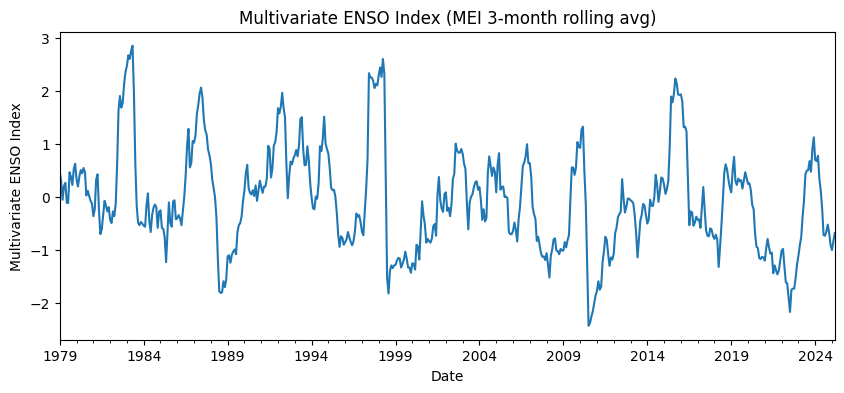

In [40]:
mei['MEI'].plot(title='Multivariate ENSO Index (MEI 3-month rolling avg)', figsize=(10,4))
plt.ylabel('Multivariate ENSO Index')
plt.show()

In [41]:
aic_ar = {}
for p in range(1, 13):
    try:
        m = AutoReg(mei['MEI'], lags=p, old_names=False).fit()
        aic_ar[p] = m.aic
    except:
        pass

best_p = min(aic_ar, key=aic_ar.get)
print(f"Best AR({best_p}) by AIC = {aic_ar[best_p]:.2f}")
ar_model = AutoReg(mei['MEI'], lags=best_p, old_names=False).fit()
print(ar_model.summary())

Best AR(6) by AIC = 175.56
                            AutoReg Model Results                             
Dep. Variable:                    MEI   No. Observations:                  555
Model:                     AutoReg(6)   Log Likelihood                 -79.778
Method:               Conditional MLE   S.D. of innovations              0.280
Date:                Fri, 09 May 2025   AIC                            175.556
Time:                        07:34:37   BIC                            210.021
Sample:                    07-01-1979   HQIC                           189.025
                         - 03-01-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0055      0.012     -0.462      0.644      -0.029       0.018
MEI.L1         1.4418      0.042     33.986      0.000       1.359       1.525
MEI.L2        -0.8211    

In [42]:
bic_ar = {}
for p in range(1, 13):
    m = AutoReg(mei['MEI'], lags=p, old_names=False).fit()
    bic_ar[p] = m.bic

# find the p with smallest BIC
best_p_bic = min(bic_ar, key=bic_ar.get)
print(f"Best AR({best_p_bic}) by BIC = {bic_ar[best_p_bic]:.2f}")

# fit & summarize
ar_model_bic = AutoReg(mei['MEI'], lags=best_p_bic, old_names=False).fit()
print(ar_model_bic.summary())


Best AR(4) by BIC = 207.67
                            AutoReg Model Results                             
Dep. Variable:                    MEI   No. Observations:                  555
Model:                     AutoReg(4)   Log Likelihood                 -84.902
Method:               Conditional MLE   S.D. of innovations              0.282
Date:                Fri, 09 May 2025   AIC                            181.803
Time:                        07:34:38   BIC                            207.673
Sample:                    05-01-1979   HQIC                           191.912
                         - 03-01-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0061      0.012     -0.508      0.612      -0.030       0.018
MEI.L1         1.4072      0.041     34.253      0.000       1.327       1.488
MEI.L2        -0.7339    

In [43]:
# 3) ARIMA(p,d,q) grid search by AIC
aic_ari = {}
for p in range(3):
    for d in [0,1]:
        for q in range(3):
            try:
                m = ARIMA(mei['MEI'], order=(p,d,q), enforce_stationarity=True, enforce_invertibility=True).fit()
                aic_ari[(p,d,q)] = m.aic
            except:
                pass

best_ari = min(aic_ari, key=aic_ari.get)
print(f"\nBest ARIMA{best_ari} by AIC = {aic_ari[best_ari]:.2f}")
ari_model = ARIMA(mei['MEI'], order=best_ari).fit()
print(ari_model.summary())


Best ARIMA(2, 0, 2) by AIC = 186.80
                               SARIMAX Results                                
Dep. Variable:                    MEI   No. Observations:                  555
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -87.401
Date:                Fri, 09 May 2025   AIC                            186.802
Time:                        07:34:43   BIC                            212.716
Sample:                    01-01-1979   HQIC                           196.925
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0639      0.121     -0.529      0.597      -0.301       0.173
ar.L1          1.8340      0.069     26.711      0.000       1.699       1.969
ar.L2         -

In [44]:
# ARIMA by BIC
bic_ari = {}
for p in range(3):
    for d in (0,1):
        for q in range(3):
            try:
                m = ARIMA(mei['MEI'], order=(p,d,q),
                          enforce_stationarity=True,
                          enforce_invertibility=True).fit()
                bic_ari[(p,d,q)] = m.bic
            except:
                pass

best_ari_bic = min(bic_ari, key=bic_ari.get)
print("Best ARIMA by BIC:", best_ari_bic, bic_ari[best_ari_bic])

Best ARIMA by BIC: (1, 0, 1) 205.05668520220212


In [45]:
ari_model_bic = ARIMA(mei['MEI'], order=best_ari_bic).fit()
print(ari_model_bic.summary())

                               SARIMAX Results                                
Dep. Variable:                    MEI   No. Observations:                  555
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -89.890
Date:                Fri, 09 May 2025   AIC                            187.781
Time:                        07:34:50   BIC                            205.057
Sample:                    01-01-1979   HQIC                           194.529
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0651      0.185     -0.352      0.725      -0.428       0.297
ar.L1          0.8903      0.018     49.001      0.000       0.855       0.926
ma.L1          0.5944      0.030     20.042      0.0

In [46]:
# 4) SARIMAX seasonal grid by AIC
aic_sx = {}
pdq_choices = [(1,0,1), (0,1,1), (1,1,1)]
seasonal_choices = [(1,0,1,12), (0,1,1,12), (1,1,1,12)]
for pdq in pdq_choices:
    for s in seasonal_choices:
        try:
            m = SARIMAX(mei['MEI'], order=pdq, seasonal_order=s,
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            aic_sx[(pdq,s)] = m.aic
        except:
            pass

best_sx = min(aic_sx, key=aic_sx.get)
print(f"\nBest SARIMAX{best_sx} by AIC = {aic_sx[best_sx]:.2f}")
sx_model = SARIMAX(mei['MEI'], order=best_sx[0], seasonal_order=best_sx[1],
                   enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
print(sx_model.summary())


Best SARIMAX((1, 0, 1), (1, 0, 1, 12)) by AIC = 185.79
                                     SARIMAX Results                                      
Dep. Variable:                                MEI   No. Observations:                  555
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 -87.895
Date:                            Fri, 09 May 2025   AIC                            185.790
Time:                                    07:35:02   BIC                            207.257
Sample:                                01-01-1979   HQIC                           194.185
                                     - 03-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8952      0.018     48.417      0.000    

In [47]:
# SARIMAX by BIC
bic_sx = {}
for pdq in pdq_choices:
    for seas in seasonal_choices:
        try:
            m = SARIMAX(mei['MEI'],
                        order=pdq,
                        seasonal_order=seas,
                        enforce_stationarity=True,
                        enforce_invertibility=True).fit(disp=False)
            bic_sx[(pdq, seas)] = m.bic
        except:
            pass

best_sx_bic = min(bic_sx, key=bic_sx.get)
print("Best SARIMAX by BIC:", best_sx_bic, bic_sx[best_sx_bic])

Best SARIMAX by BIC: ((1, 0, 1), (1, 0, 1, 12)) 208.45663989135068


In [48]:
sx_model_bic = SARIMAX(mei['MEI'], order=best_sx_bic[0], seasonal_order=best_sx_bic[1],
                   enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
print(sx_model_bic.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                MEI   No. Observations:                  555
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 -87.895
Date:                            Fri, 09 May 2025   AIC                            185.790
Time:                                    07:35:21   BIC                            207.257
Sample:                                01-01-1979   HQIC                           194.185
                                     - 03-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8952      0.018     48.417      0.000       0.859       0.931
ma.L1          0.5881      0.030   

In [49]:
# 5) Holt–Winters additive seasonal
hw_model = ExponentialSmoothing(mei['MEI'], trend='add',
                                seasonal='add', seasonal_periods=12).fit()
print(f"\nHolt–Winters SSE = {hw_model.sse:.2f}")


Holt–Winters SSE = 58.32


In [50]:
# 6) Conclusion
print("\nConclusion:")
print(f"- AR({best_p}) AIC = {aic_ar[best_p]:.2f}")
print(f"- ARIMA{best_ari} AIC = {aic_ari[best_ari]:.2f}")
print(f"- SARIMAX{best_sx} AIC = {aic_sx[best_sx]:.2f}")
print("By BIC")
print(f"- AR({best_p_bic}) BIC = {bic_ar[best_p_bic]:.2f}")
print(f"- ARIMA{best_ari_bic} BIC = {bic_ari[best_ari_bic]:.2f}")
print(f"- SARIMAX{best_sx_bic} BIC = {bic_sx[best_sx_bic]:.2f}")
print(f"- Holt–Winters SSE = {hw_model.sse:.2f}")


Conclusion:
- AR(6) AIC = 175.56
- ARIMA(2, 0, 2) AIC = 186.80
- SARIMAX((1, 0, 1), (1, 0, 1, 12)) AIC = 185.79
By BIC
- AR(4) BIC = 207.67
- ARIMA(1, 0, 1) BIC = 205.06
- SARIMAX((1, 0, 1), (1, 0, 1, 12)) BIC = 208.46
- Holt–Winters SSE = 58.32


In [51]:
# AIC based DW and Breusch–Godfrey LM Test
fitted = {
    'AR':       ar_model,
    'ARIMA':    ari_model,
    'SARIMAX':  sx_model
}

for name, res in fitted.items():
    print(f"\n=== {name} Model ===")

    # 1) Durbin–Watson
    dw = durbin_watson(res.resid)
    print(f"Durbin–Watson statistic: {dw:.3f}")
    if    dw < 1.8:  dw_interp = "strong positive autocorrelation"
    elif  dw > 2.2:  dw_interp = "strong negative autocorrelation"
    else:            dw_interp = "little to no autocorrelation"
    print("  → Interpretation:", dw_interp)

    # 2) Breusch–Godfrey LM test
    #    nlags=12 is typical for monthly data (you can adjust)
    lm_stat, lm_pvalue, _, _ = acorr_breusch_godfrey(res, nlags=12)
    print(f"Breusch–Godfrey LM stat: {lm_stat:.2f}, p‐value: {lm_pvalue:.3f}")
    if lm_pvalue < 0.05:
        bg_interp = "reject H0 → residual autocorrelation present"
    else:
        bg_interp = "fail to reject H0 → no evidence of autocorrelation"
    print("  → Interpretation:", bg_interp)



=== AR Model ===
Durbin–Watson statistic: 2.003
  → Interpretation: little to no autocorrelation
Breusch–Godfrey LM stat: 5.84, p‐value: 0.924
  → Interpretation: fail to reject H0 → no evidence of autocorrelation

=== ARIMA Model ===
Durbin–Watson statistic: 2.120
  → Interpretation: little to no autocorrelation
Breusch–Godfrey LM stat: 14.67, p‐value: 0.260
  → Interpretation: fail to reject H0 → no evidence of autocorrelation

=== SARIMAX Model ===
Durbin–Watson statistic: 2.078
  → Interpretation: little to no autocorrelation
Breusch–Godfrey LM stat: 16.67, p‐value: 0.163
  → Interpretation: fail to reject H0 → no evidence of autocorrelation


In [52]:
# BIC based DW and Breusch–Godfrey LM Test
fitted = {
    'AR':       ar_model_bic,
    'ARIMA':    ari_model_bic,
    'SARIMAX':  sx_model_bic
}

for name, res in fitted.items():
    print(f"\n=== {name} Model ===")

    # 1) Durbin–Watson
    dw = durbin_watson(res.resid)
    print(f"Durbin–Watson statistic: {dw:.3f}")
    if    dw < 1.8:  dw_interp = "strong positive autocorrelation"
    elif  dw > 2.2:  dw_interp = "strong negative autocorrelation"
    else:            dw_interp = "little to no autocorrelation"
    print("  → Interpretation:", dw_interp)

    # 2) Breusch–Godfrey LM test
    #    nlags=12 is typical for monthly data (you can adjust)
    lm_stat, lm_pvalue, _, _ = acorr_breusch_godfrey(res, nlags=12)
    print(f"Breusch–Godfrey LM stat: {lm_stat:.2f}, p‐value: {lm_pvalue:.3f}")
    if lm_pvalue < 0.05:
        bg_interp = "reject H0 → residual autocorrelation present"
    else:
        bg_interp = "fail to reject H0 → no evidence of autocorrelation"
    print("  → Interpretation:", bg_interp)


=== AR Model ===
Durbin–Watson statistic: 1.950
  → Interpretation: little to no autocorrelation
Breusch–Godfrey LM stat: 16.91, p‐value: 0.153
  → Interpretation: fail to reject H0 → no evidence of autocorrelation

=== ARIMA Model ===
Durbin–Watson statistic: 2.074
  → Interpretation: little to no autocorrelation
Breusch–Godfrey LM stat: 11.91, p‐value: 0.453
  → Interpretation: fail to reject H0 → no evidence of autocorrelation

=== SARIMAX Model ===
Durbin–Watson statistic: 2.078
  → Interpretation: little to no autocorrelation
Breusch–Godfrey LM stat: 16.67, p‐value: 0.163
  → Interpretation: fail to reject H0 → no evidence of autocorrelation


# Stocks Part Start

In [19]:
!pip install curl_cffi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.8 MB/s eta 0:00:00


In [53]:
raw = pd.read_csv('NEE_BEP_DNNGY_CWEN.csv')

In [83]:
from curl_cffi import requests
session = requests.Session(impersonate="chrome")
  # ticker = yf.Ticker('...', session=session)

In [54]:
tickers = {
    #'First Solar'  : {'ticker': 'FSLR', 'renewal_date': '2008-01-01'},
    'Next Era'     : {'ticker': 'NEE', 'renewal_date': '2005-01-01'},
    'Brookfield'   : {'ticker': 'BEP', 'renewal_date': '2013-01-01'},
    #'Vestas Wind'  : {'ticker': 'VWS.CO', 'renewal_date': '2000-01-01'},
    'Orsted'       : {'ticker': 'DNNGY', 'renewal_date': '2016-01-01'},
    'Clearway Energy' : {'ticker': 'CWEN', 'renewal_date': '2018-01-01'}
}

CSIQ, DNNGY, ENPH, CWEN

https://www.kiplinger.com/investing/stocks/best-green-energy-stocks

In [120]:
# Download adjusted-close monthly data over MEI’s span
start, end = mei.index.min(), mei.index.max()
symbols = [v['ticker'] for v in tickers.values()]
raw = yf.download(symbols, start=start, end=end, auto_adjust=False, session=session)['Close']
raw

[*********************100%***********************]  4 of 4 completed


Ticker,BEP,CWEN,DNNGY,NEE
Date,,,,
1979-01-02,NaN,NaN,NaN,1.640625
1979-01-03,NaN,NaN,NaN,1.671875
1979-01-04,NaN,NaN,NaN,1.656250
1979-01-05,NaN,NaN,NaN,1.687500
1979-01-08,NaN,NaN,NaN,1.679688
...,...,...,...,...
2025-02-24,22.740000,26.700001,14.66,70.800003
2025-02-25,23.110001,27.360001,15.21,71.279999
2025-02-26,23.370001,27.750000,14.96,71.010002


In [121]:
#raw.to_csv('NEE_BEP_DNNGY_CWEN.csv')

In [55]:
symbols = [v['ticker'] for v in tickers.values()]

In [56]:
raw = raw.set_index('Date')
raw

,BEP,CWEN,DNNGY,NEE
Date,,,,
1979-01-02,NaN,NaN,NaN,1.640625
1979-01-03,NaN,NaN,NaN,1.671875
1979-01-04,NaN,NaN,NaN,1.656250
1979-01-05,NaN,NaN,NaN,1.687500
1979-01-08,NaN,NaN,NaN,1.679688
...,...,...,...,...
2025-02-24,22.740000,26.700001,14.66,70.800003
2025-02-25,23.110001,27.360001,15.21,71.279999
2025-02-26,23.370001,27.750000,14.96,71.010002


In [60]:
raw.index = pd.to_datetime(raw.index)

In [61]:
prices = raw.resample('MS').last()

In [62]:
# 3. DETREND & OVERPLOT CYCLES vs. MEI
cycles = pd.DataFrame(index=prices.index)

for name, info in tickers.items():
    s = prices[info['ticker']].dropna()
    # HP‐filter into cycle & trend components (λ=129600 ≃ monthly data)
    cycle, trend = hpfilter(s, lamb=129600)
    cycles[name] = cycle

# Ensure MEI has datetime index
if not isinstance(mei.index, pd.DatetimeIndex):
    mei = mei.set_index('Date')

# Find the overlapping period between MEI and stock data
#start_date = max(mei.index.min(), cycles.index.min())
#end_date = min(mei.index.max(), cycles.index.max())

start_date = '2000-01-01'
end_date = '2025-01-01'

# Create a filtered dataframe
#df_filtered = [start_date:end_date]
#mei_filtered = df[start_date:end_date]

# Filter both datasets to the overlapping period
mei_filtered = mei.loc[start_date:end_date]
cycles_filtered = cycles.loc[start_date:end_date]

In [63]:
# Instead of dropping NAs, which removes rows with any missing values
df = pd.concat([mei_filtered['MEI'], cycles_filtered], axis=1)

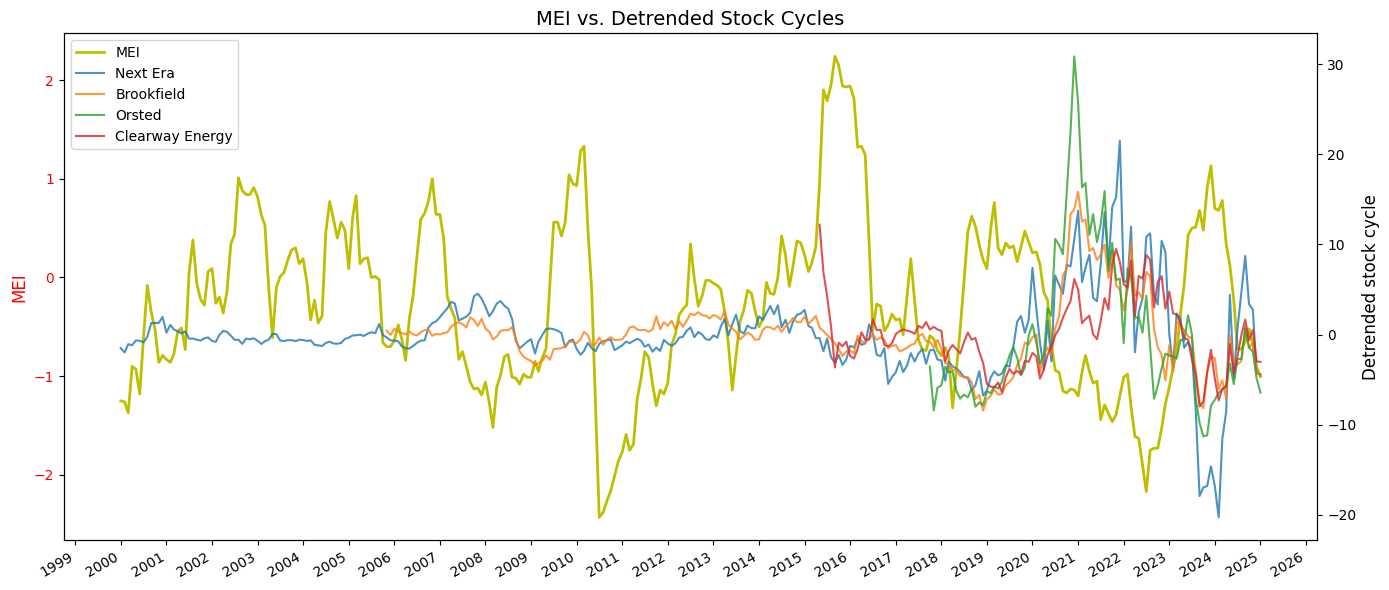

In [64]:
# Plot with handling of missing values
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

# Plot MEI on left y-axis (with gaps where data is missing)
ax1.plot(df.index, df['MEI'], color='y', linewidth=2, label='MEI')
ax1.set_ylabel('MEI', fontsize=12, color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Plot stock cycles on right y-axis (with gaps where data is missing)
for column in cycles_filtered.columns:
    ax2.plot(df.index, df[column], linewidth=1.5, alpha=0.8, label=column)

ax2.set_ylabel('Detrended stock cycle', fontsize=12)
ax1.set_title('MEI vs. Detrended Stock Cycles', fontsize=14)

# Improve x-axis formatting
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()

# Create legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True)

plt.tight_layout()
plt.show()


In [65]:
# Using method='pairwise' to only consider available pairs of observations
correlation = df.corr(method='pearson', min_periods=30)
print("Correlation of MEI with each stock cycle:\n", correlation.loc['MEI', cycles_filtered.columns])

Correlation of MEI with each stock cycle:
 Next Era          -0.391628
Brookfield        -0.358705
Orsted            -0.514565
Clearway Energy   -0.498977
Name: MEI, dtype: float64


#### Not used

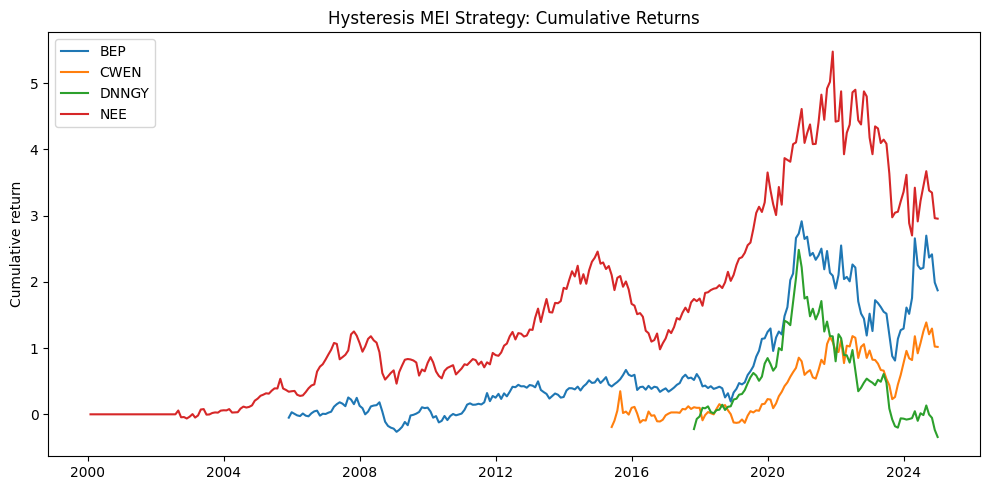

Final cumulative returns:
BEP      187.3%
CWEN     101.8%
DNNGY    -34.3%
NEE      295.5%
Name: 2025-01-01 00:00:00, dtype: object


In [66]:
# build the z‐score of MEI
mu, sigma = mei_filtered['MEI'].mean(), mei_filtered['MEI'].std()
z = (mei_filtered['MEI'] - mu) / sigma

# build a hysteresis signal series
signal = pd.Series(0, index=mei_filtered.index, dtype=int)
state = 0   #  0 = flat, +1 = long, -1 = short

for t in mei_filtered.index:
    if state != -1 and z.loc[t] >  1.5:
        # MEI has gone > +1σ → go short
        state = -1
    elif state == -1 and z.loc[t] < 1:
        # MEI has retreated below +0.5σ → reverse to long
        state = +1
    # otherwise keep the same state
    signal.loc[t] = state

# ----- compute strategy returns on actual price returns -----
price_ret = prices.resample('MS').last().pct_change().loc[signal.index]
strat_ret = price_ret.mul(signal.shift(1), axis=0)  # shift to avoid look‐ahead

# ----- cumulative performance -----
cum_ret = (1 + strat_ret).cumprod().subtract(1)

plt.figure(figsize=(10,5))
for col in cum_ret:
    plt.plot(cum_ret.index, cum_ret[col], label=col)
plt.title("Hysteresis MEI Strategy: Cumulative Returns")
plt.ylabel("Cumulative return")
plt.legend()
plt.tight_layout()
plt.show()

print("Final cumulative returns:")
print((cum_ret.iloc[-1]*100).round(1).astype(str) + "%")


#### Used

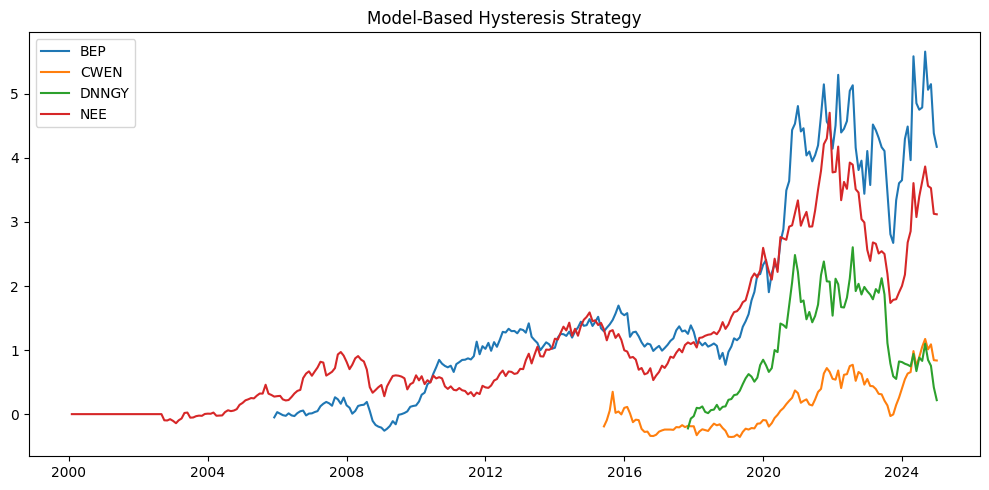

Final returns: BEP      417.3%
CWEN      83.7%
DNNGY     21.8%
NEE      312.0%
Name: 2025-01-01 00:00:00, dtype: object


In [99]:
#mei_fc = ar_model.predict(start=mei_filtered.index[0],end=mei_filtered.index[-1])
mei_fc = sx_model.predict(start=mei_filtered.index[0],end=mei_filtered.index[-1])

mei_fc = pd.Series(mei_fc, index=mei_filtered.index)

# 2) z‐score the *forecast* ----
mu, sigma = mei_filtered['MEI'].mean(), mei_filtered['MEI'].std()
z_fc = (mei_fc - mu) / sigma

# 3) hysteresis on the forecasted z‐score ----
signal = pd.Series(0, index=mei_filtered.index, dtype=int)
state = 0
for t in mei_filtered.index:
    if state != -1 and (z_fc.loc[t] >  1.5 or z_fc.loc[t] <  -1.5):
    #if state != -1 and (z_fc.loc[t] >  1.5):
        state = -1       # forecast strongly positive → short
    elif state == -1 and z_fc.loc[t] < 1.25: #and z_fc.loc[prev_t] < 1.25:
        state = +1       # forecast has pulled back → long
    #prev_t = t - pd.tseries.frequencies.to_offset('MS')
    signal.loc[t] = state

# 4) apply to price returns and compute P&L ----
price_ret = prices.resample('MS').last().pct_change().loc[signal.index]
strat_ret = price_ret.mul(signal.shift(1), axis=0)

cum_ret = (1 + strat_ret).cumprod().subtract(1)
plt.figure(figsize=(10,5))
for col in cum_ret:
    plt.plot(cum_ret.index, cum_ret[col], label=col)
plt.title("Model-Based Hysteresis Strategy")
plt.legend(); plt.tight_layout(); plt.show()

print("Final returns:", (cum_ret.iloc[-1]*100).round(1).astype(str) + "%")


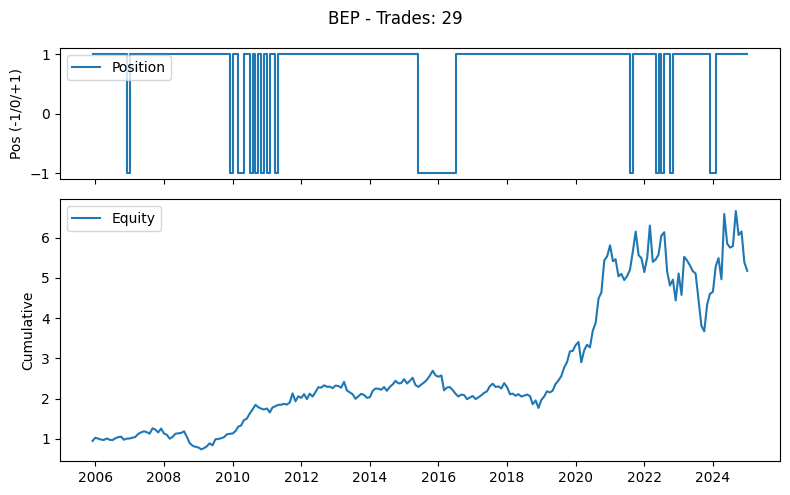


=== BEP Trades ===
symbol      entry       exit  signal  trade_return  holding_months
   BEP 2005-12-01 2006-11-01       1     -0.020184              12
   BEP 2006-12-01 2006-12-01      -1      0.029338               1
   BEP 2007-01-01 2009-11-01       1      0.105041              35
   BEP 2009-12-01 2009-12-01      -1      0.011609               1
   BEP 2010-01-01 2010-02-01       1      0.061422               2
   BEP 2010-03-01 2010-04-01      -1      0.115927               2
   BEP 2010-05-01 2010-06-01       1      0.127218               2
   BEP 2010-07-01 2010-07-01      -1      0.081784               1
   BEP 2010-08-01 2010-08-01       1      0.063328               1
   BEP 2010-09-01 2010-09-01      -1      0.066562               1
   BEP 2010-10-01 2010-10-01       1     -0.031941               1
   BEP 2010-11-01 2010-11-01      -1     -0.020000               1
   BEP 2010-12-01 2010-12-01       1     -0.012148               1
   BEP 2011-01-01 2011-01-01      -1      

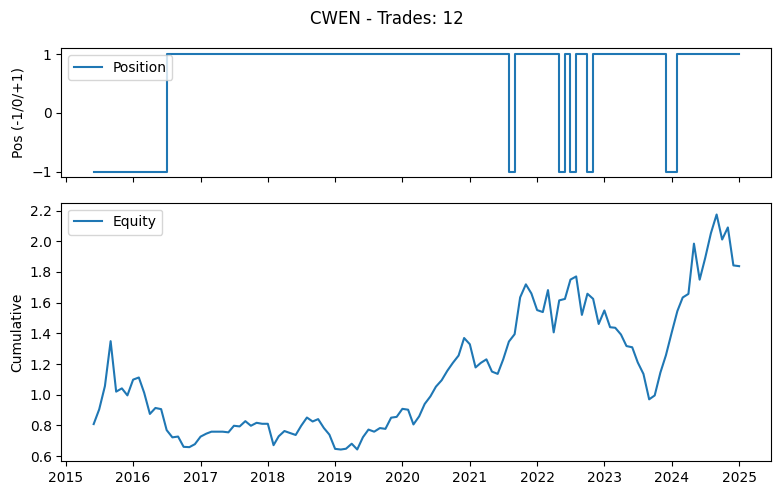


=== CWEN Trades ===
symbol      entry       exit  signal  trade_return  holding_months
  CWEN 2015-06-01 2016-06-01      -1     -0.094074              13
  CWEN 2016-07-01 2021-07-01       1      0.357684              61
  CWEN 2021-08-01 2021-08-01      -1      0.094491               1
  CWEN 2021-09-01 2022-04-01       1      0.044576               8
  CWEN 2022-05-01 2022-05-01      -1      0.148051               1
  CWEN 2022-06-01 2022-06-01       1      0.005991               1
  CWEN 2022-07-01 2022-07-01      -1      0.077497               1
  CWEN 2022-08-01 2022-09-01       1     -0.131447               2
  CWEN 2022-10-01 2022-10-01      -1      0.090738               1
  CWEN 2022-11-01 2023-11-01       1     -0.309626              13
  CWEN 2023-12-01 2024-01-01      -1      0.226272               2
  CWEN 2024-02-01 2025-01-01       1      0.309180              12


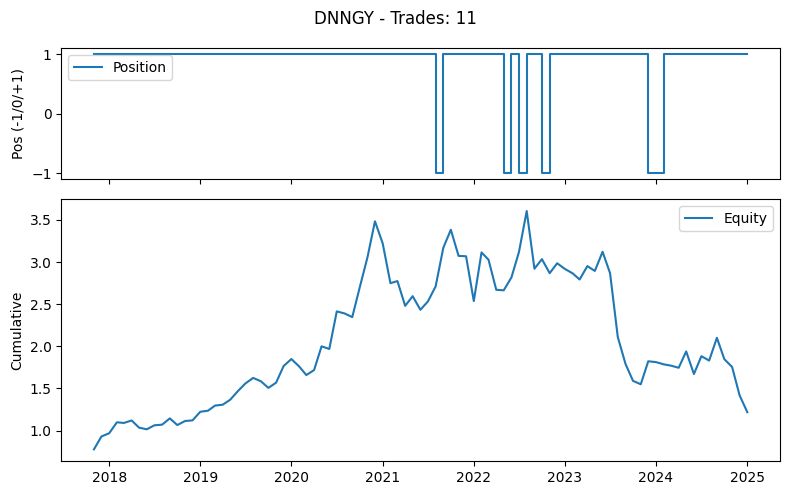


=== DNNGY Trades ===
symbol      entry       exit  signal  trade_return  holding_months
 DNNGY 2017-11-01 2021-07-01       1      1.532110              45
 DNNGY 2021-08-01 2021-08-01      -1      0.070451               1
 DNNGY 2021-09-01 2022-04-01       1     -0.014612               8
 DNNGY 2022-05-01 2022-05-01      -1     -0.002420               1
 DNNGY 2022-06-01 2022-06-01       1      0.057951               1
 DNNGY 2022-07-01 2022-07-01      -1      0.106724               1
 DNNGY 2022-08-01 2022-09-01       1     -0.063744               2
 DNNGY 2022-10-01 2022-10-01      -1      0.038927               1
 DNNGY 2022-11-01 2023-11-01       1     -0.489336              13
 DNNGY 2023-12-01 2024-01-01      -1      0.169751               2
 DNNGY 2024-02-01 2025-01-01       1     -0.328021              12


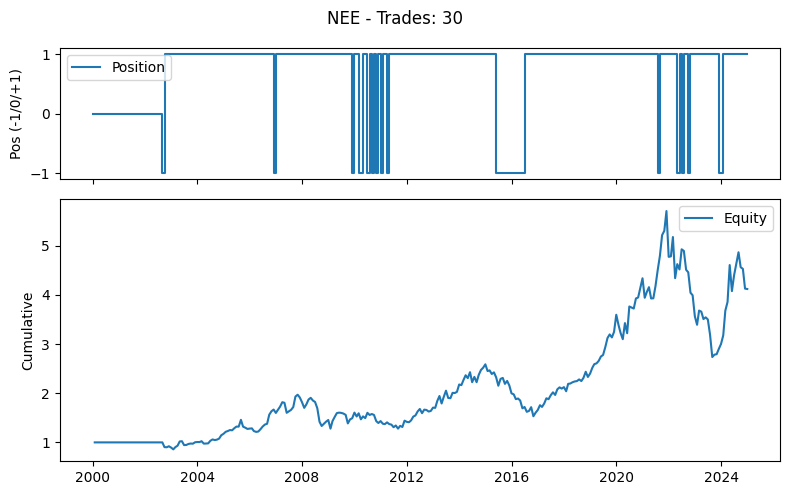


=== NEE Trades ===
symbol      entry       exit  signal  trade_return  holding_months
   NEE 2002-09-01 2002-09-01      -1      0.000000               1
   NEE 2002-10-01 2006-11-01       1      0.633372              50
   NEE 2006-12-01 2006-12-01      -1      0.021013               1
   NEE 2007-01-01 2009-11-01       1     -0.120205              35
   NEE 2009-12-01 2009-12-01      -1      0.016356               1
   NEE 2010-01-01 2010-02-01       1      0.024082               2
   NEE 2010-03-01 2010-04-01      -1     -0.037955               2
   NEE 2010-05-01 2010-06-01       1      0.016343               2
   NEE 2010-07-01 2010-07-01      -1      0.072601               1
   NEE 2010-08-01 2010-08-01       1     -0.027342               1
   NEE 2010-09-01 2010-09-01      -1      0.012284               1
   NEE 2010-10-01 2010-10-01       1     -0.011951               1
   NEE 2010-11-01 2010-11-01      -1     -0.080305               1
   NEE 2010-12-01 2010-12-01       1     -

In [100]:
results = []

for sym in strat_ret.columns:
    # --- a) assemble per-symbol DataFrame ---
    df_i = pd.DataFrame({
        'signal':   signal,
        'strat_ret':strat_ret[sym],
        'price_ret':price_ret[sym]
    }).dropna(subset=['price_ret'])
    df_i['pos_change'] = df_i['signal'].diff().fillna(0)
    df_i['trade_id']   = (df_i['pos_change'] != 0).cumsum()

    # --- b) trade-by-trade stats (unchanged) ---
    trades = []
    for tid in df_i.loc[df_i.signal != 0, 'trade_id'].unique():
        tr = df_i[df_i.trade_id == tid]
        trades.append({
            'symbol':         sym,
            'entry':          tr.index[0],
            'exit':           tr.index[-1],
            'signal':       tr.signal.iloc[0],
            'trade_return':   (1 + tr['strat_ret']).prod() - 1,
            'holding_months': len(tr)
        })
    trades_df = pd.DataFrame(trades)

    # --- c) strategy metrics ---
    strat_sr     = df_i['strat_ret'].mean() / df_i['strat_ret'].std() * np.sqrt(12)
    strat_equity = (1 + df_i['strat_ret']).cumprod()
    strat_dd     = (strat_equity / strat_equity.cummax() - 1).min()
    strat_turn   = df_i['pos_change'].abs().sum()/2 / len(df_i)
    strat_hp     = trades_df['holding_months'].mean() if not trades_df.empty else np.nan

    # --- d) buy-&-hold metrics on the same price_ret ---
    bh_sr     = df_i['price_ret'].mean() / df_i['price_ret'].std() * np.sqrt(12)
    bh_equity = (1 + df_i['price_ret']).cumprod()
    bh_dd     = (bh_equity / bh_equity.cummax() - 1).min()
    # turnover = 0, holding = whole sample
    bh_turn   = 0.0
    bh_hp     = len(df_i)

    # --- e) collect results ---
    results.append({
        'symbol':       sym,
        # strategy
        'STR Sharpe':   strat_sr,
        'STR MaxDD%':   strat_dd*100,
        'STR Turnover': strat_turn,
        'STR AvgHold':  strat_hp,
        # buy-&-hold
        'BH Sharpe':    bh_sr,
        'BH MaxDD%':    bh_dd*100,
        'BH Turnover':  bh_turn,
        'BH AvgHold':   bh_hp,
        'NumTrades':    len(trades_df)
    })

    # d) plot for this symbol
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,5), sharex=True,
                                   gridspec_kw={'height_ratios':[1,2]})
    ax1.step(df_i.index, df_i.signal, where='post', label='Position')
    ax1.set_ylabel('Pos (-1/0/+1)')
    ax1.legend(loc='upper left')

    ax2.plot(strat_equity, label='Equity')
    ax2.set_ylabel('Cumulative')
    ax2.legend()
    fig.suptitle(f"{sym} - Trades: {len(trades_df)}")
    plt.tight_layout()
    plt.show()

    # e) print that symbol's trades
    print(f"\n=== {sym} Trades ===")
    print(trades_df.to_string(index=False))

# f) summary table
metrics_df = pd.DataFrame(results).set_index('symbol')
print("\n=== Strategy Summary ===")
print(metrics_df)


# Summary (AI generated): Trading Energy Stocks with MEI Models

## 1. Data Preparation  
We assembled two time series:  
- **Multivariate ENSO Index (MEI).**  
  - Loaded monthly MEI from 1979 onward, parsed dates, and forced a consistent month‐start frequency.  
- **Renewable‐energy stock prices.**  
  - Downloaded monthly closes for a basket of pure‐play names (e.g. BEP, CWEN, DNNGY, NEE).  
  - Applied an HP‐filter (λ=129 600) to extract each stock’s cyclical component, isolating short‐term price fluctuations.  

## 2. Modeling MEI Dynamics  
We tested three common time‐series approaches:  
- **Autoregression (AR).**  
  - Selected AR(6) by minimizing AIC; its coefficients exhibited very slow decay, confirming multi-month persistence.  
- **ARIMA.**  
  - Explored small (p,d,q) grids; ARIMA(2,0,2) was best by AIC but offered no diagnostic improvement over AR(6).  
- **Seasonal SARIMAX.**  
  - Fitted a handful of monthly‐seasonal specifications; SARIMAX(1,0,1)(1,0,1,12) passed serial-corr tests but added complexity for minimal gain.  

All three models produced residuals indistinguishable from white noise (Durbin–Watson ≈2, Breusch–Godfrey p≫0.05).

## 3. Generating Trading Signals  
- We used the **AR(6)** one-step-ahead forecast of MEI as our signal (optionally interchangeable with the SARIMAX forecast).  
- Converted forecasts into **z-scores** against the in-sample MEI mean and standard deviation.  
- Applied a **hysteresis rule**:  
  - **Short** (–1) when forecast z > +1.5σ.  
  - **Reverse to long** (+1) when forecast z falls below +1.25σ.  
  - **Flat** until the first trigger, avoiding over-trading in a narrow band.

## 4. Strategy Implementation  
- At each month-end we take the forecast-driven position and apply it to the **next month’s actual price return** of each stock.  
- Equity grows by compounding (1 + monthly strategy return).

## 5. Trade-by-Trade Analysis & Metrics  
For each name we:  
- **Identified** entry/exit dates, direction, holding months, and trade return.  
- **Computed** overall metrics:  
  - **Sharpe ratio** (annualized)  
  - **Max draw-down**  
  - **Turnover rate** (full round-trips per month)  
  - **Average holding period**

| Symbol | Trades | Sharpe | Max DD  | Turnover/mo | Avg Hold (mo) |
|:------:|:------:|:------:|:-------:|:-----------:|:-------------:|
| BEP    | 29      | 0.48   | –41.7%  | 0.121       | 7.93          |
| CWEN   | 12      | 0.36   | –52.3%  | 0.095       | 9.67          |
| DNNGY  | 11      | 0.25  | –66.0%  | 0.115       | 7.91          |
| NEE    | 30     | 0.40   | –52.0%  | 0.098       | 8.97          |

## 6. Key Takeaways  
- MEI is a **strongly persistent** monthly series; a mid-lag AR captures most of its dynamics. SARIMAX also works
- A simple **hysteresis** on the SARIMAX forecast produces a manageable signal with limited churn.  
- **Performance varies** by ticker:  
  - Better Sharpe than Buy & Hold: BEP 0.48 (vs 0.32), CWEN 0.36 (vs 0.13), DNNGY 0.25 (vs 0.012)
  - Poor:  NEE 0.4 (vs 0.61)  
- **Next steps** could include regime-switching models, threshold optimization, and integration of fundamental/seasonal demand indicators.